# XAI 2024 TP5

## PostHoc methods - Tabular data



Author: Arthur Babey

Due: 30.04.2025, 23h59

- Professor: Carlos Peña (<a href="mailto:carlos.pena@heig-vd.ch">carlos.pena@heig-vd.ch</a>)
- Assistant 2024: Arthur Babey (<a href="mailto:arthur.babey@heig-vd.ch">arthur.babey@heig-vd.ch</a>)


Date: Spring 2025

* You will need to fill code and answer questions in this notebook

You have a folder named XAI_TP5_2024 that is structured in the following way:


XAI_TP4_2025_Tabular/

	data/
		winequality-red.csv
        
	model/
		regressor2025.pkl
                
	XAI_TP4_2025_NOM_PRENOM.ipynb

## Instructions

During this TP we will use the (same as TP3) [dataset](https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009) which contains various measurements and ratings for the wine quality.

Your tasks will be to complete the code, generate plots, and answer questions related to the following goals:

Goal :

0. Explore : explore and preprocess the dataset 
1. Model : create a regression model and compute metrics 
2. Global explanation : compute global feature importance values and generate plot
3. Local explanation : compute local feature importance to understand the model behaviour at instance level
4. Open the black box : explain a new model using the different methods 
5. Compute Lime : compute lime values from scratch


In [59]:
# import all the libraries
import sys
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shap
import lime

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

## 0. Explore and prepare the dataset




- The first step is to read and split our dataset into training and test parts. 

- If necessary (mac or linux) modify the path of your original dataset.




In [2]:
# PATHs and seed for reproducibility

dataset_path = os.path.join("data", "winequality-red.csv")
SEED = 2023

In [3]:
#load the data inot a pandas dataframe

df = pd.read_csv(dataset_path)
column_names = list(df.columns)
print(df["quality"].unique())
# substract quality by three to reduce the labels size 
df["quality"] = df["quality"]-3

df.head()

[5 6 7 4 8 3]


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,2
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,2
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,2


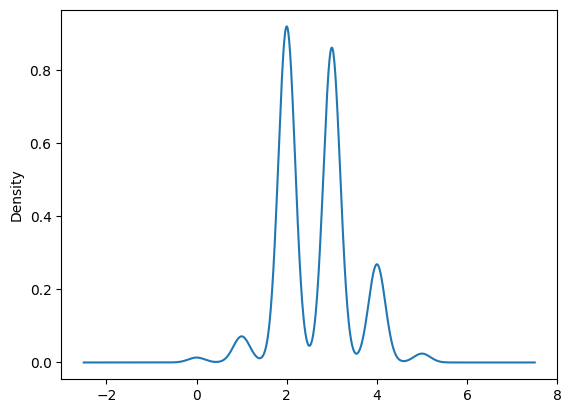

In [4]:
# we can have a look at the label distribution
df['quality'].plot(kind='density')

# display the plot
plt.show()

In [5]:
# split the dataset into a train and a test set 
# the quality feature will be our label vector (y)

X = df.drop("quality", axis=1)
y = df['quality']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

## 1. Modeling with a standard ML method 

In the code below you have an implementation of a machine learning model, you will need to : 

1. Train a model and make a prediction with it
2. Compute metrics to evaluate your model


### Regression or Classification with a Decision Tree

Since the output variables are ordered (with 0 being low quality and 5 being high quality), we can perform regression using the DecisionTreeRegressor from the scikit-learn API. : [regressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html).

### Complete the code below to : 

1. Create a model using DecisionTree (use random_state = SEED) for reproducibility
2. Train it with the training data 
3. Make prediction on the test set
4. Compute, print and interpret the (root) mean squared error 

In [6]:
# YOUR CODE 
# name your model "regressor"
regressor = DecisionTreeRegressor(random_state=SEED)

regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

In [7]:
# YOUR CODE 
# print the metrics here
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

Mean Squared Error (MSE): 0.7937
Root Mean Squared Error (RMSE): 0.8909


These scores are decent, on average our model is off by less than 1 quality point.

---
*Réservé pour corrections*
<div class="alert alert-block alert-info">
<b>Corrections: /4 </b>
</div>

Commentaires: 

## 2. Global explanation : Feature Importance exploration

Now that we have a model we can try to understand how it is working

In the code below, you will need to : 

1. Compute Feature Importance using : 
    - Built in feature importance method
    - Other Post-Hoc methods
2. Plot you result 
3. Compare your result

### 2.1 Built in Feature Importance exploration :


Here's an example of how to compute feature importance using built-in methods. Many machine learning models have a built-in method to compute feature importance, such as tree models, SVMs, XGBoost, etc. However, this method is limited and often non-consistent.


In [8]:
# If you failed to train a regressor model, you can continue the lab by loading this one by running this cell.

from joblib import load

# Load the regressor model from the specified path
regressor2 = load('model/regressor2025.pkl')

print("Regressor2 model loaded successfully.")

Regressor2 model loaded successfully.


In [9]:
# Get the feature importances
re_importances = regressor.feature_importances_

# The higher values means the more important is the feature. The importance of a feature is computed as the
# Total reduction of the criterion brought by that feature known as Gini importance


# Print the feature importances
for i, feature in enumerate(X.columns):
    print(f"Regressor importance - {feature:<20}: {re_importances[i]:.2f}")

# check that the sum of importance = 1
print(f"Regressor's importances sum is = {re_importances.sum()}")

Regressor importance - fixed acidity       : 0.05
Regressor importance - volatile acidity    : 0.13
Regressor importance - citric acid         : 0.04
Regressor importance - residual sugar      : 0.05
Regressor importance - chlorides           : 0.06
Regressor importance - free sulfur dioxide : 0.05
Regressor importance - total sulfur dioxide: 0.10
Regressor importance - density             : 0.06
Regressor importance - pH                  : 0.04
Regressor importance - sulphates           : 0.12
Regressor importance - alcohol             : 0.29
Regressor's importances sum is = 1.0


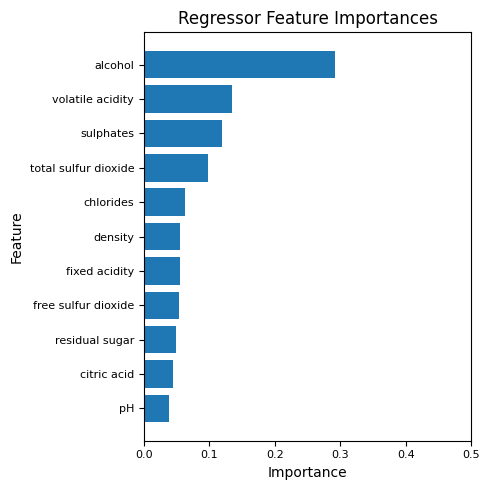

In [10]:
# Create a figure with one subplot
fig, ax = plt.subplots(figsize=(5, 5))

# Plot the second set of data
sorted_idx = re_importances.argsort()[::-1]
sorted_importances = re_importances[sorted_idx][::-1]
sorted_features = X.columns[sorted_idx][::-1]

ax.barh(sorted_features, sorted_importances)
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')
ax.set_title('Regressor Feature Importances')
ax.yaxis.set_ticks(sorted_features)
ax.tick_params(axis='x', labelsize=8)
ax.set_yticklabels(sorted_features, fontsize=8)
ax.set_xlim([0, 0.5])

# Adjust the layout of the subplot
fig.tight_layout()

# Show the plot
plt.show()

---
#### Note :

- Ok so this is interesting but : we can do **better**. We do not have local explanation, we can not see the **heterogeneity** in the population nor the **interactions** between features

- We need to use XAI methods to have a better understanding at what's going on

---

### 2.2 Explaining Feature Importances with Post-Hoc Methods

- To gain deeper insights into both global and local feature importances, we will use **post-hoc** methods. These techniques are designed to explain the behavior of complex models and how they make predictions.

- We will specifically use two post-hoc methods: **LIME** and **SHAP**, both of which are **model-agnostic**—meaning they can provide explanations for any type of model.

- Complete the code below to compute and print the **global SHAP values** on the **test set**:

In [11]:
# create explainer object on our regressor model
explainer_re = shap.TreeExplainer(regressor, feature_names=X_test.columns.tolist())

explainer_re

In [12]:
# compute shap values on the scaled test set
shap_values = explainer_re.shap_values(X_test)

# we can have a look at the shap values for each instance in the test set
pd.DataFrame(shap_values, columns=X_test.columns.tolist()).head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,-0.005358,0.073968,-0.041368,-0.022200,0.036315,0.018104,0.058612,0.034717,-0.018810,-0.493047,-0.276586
1,-0.064718,-0.226143,0.035708,-0.022729,-0.032612,0.201791,-0.079290,0.005332,0.022034,0.059504,-0.534532
2,0.069690,0.196711,-0.012869,0.009388,0.239121,-0.022129,0.216230,0.067962,0.014235,0.516745,0.069263
3,-0.016533,0.010238,-0.016180,-0.042915,0.066576,0.034865,0.003688,0.018274,-0.021144,0.230372,0.097104
4,-0.001598,-0.005990,-0.016981,-0.011906,0.009381,0.128228,0.034863,-0.010505,-0.044453,0.163426,0.119880


### Complete the code below : 

Now make a **bar plot** first and then a **beeswarm plot** of the shap values using the [shap plot API](https://shap.readthedocs.io/en/latest/api_examples.html#explainers) 



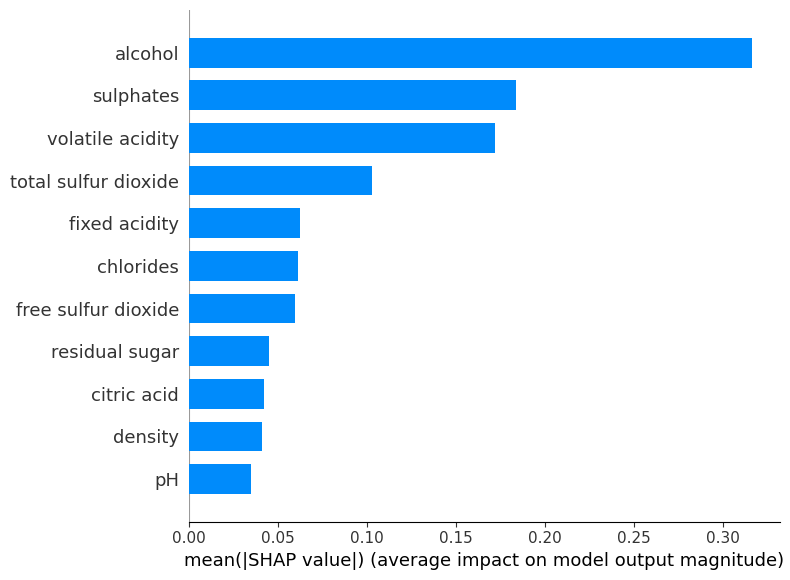

In [13]:
# YOUR CODE
# generate a bar plot
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [ ]:
# YOUR CODE
# generate a beeswarm plot
shap.summary_plot(shap_values, X_test)

NameError: name 'shap' is not defined

### Questions : 


How shap values are transformed before the bar plot ?


And the beeswarm plot ?
    
    
What benefits has the beeswarm plot ?     

*Answers:*

**Bar plot:**

SHAP values are averaged across samples in the bar plot to reflect feature importance.

**Beeswarm plot:**

The SHAP beeswarm plot displays how each feature influences the model's output across all samples. The horizontal axis ranges from approximately –1.0 to 1.0, which represents the SHAP value — i.e., the impact of a feature on the model output. A positive SHAP value means the feature increases the predicted quality, while a negative value means it decreases it.

Each dot corresponds to a single observation in the dataset:
- The position on the x-axis shows the magnitude and direction of the feature’s effect.
- The color reflects the original value of the feature: red for high values, blue for low values.

The main benefit of the beeswarm plot, as noted, is that it visualizes both the distribution and the impact of each feature at once. It allows us to interpret not only which features are important, but also how their values influence predictions.

---

*Réservé pour corrections*
<div class="alert alert-block alert-info">
<b>Corrections: /6 </b>
</div>

Commentaires: 

---

### 2.2.1 SHAP Dependence Plot

SHAP allows us to visualize the **dependence** between a feature's value and its SHAP value using the modern `shap.plots.scatter` function.

This plot helps us understand how a feature contributes to the model’s output across the dataset, and we can optionally color the points by another feature to explore **interactions**.

> Choose a feature to explain (e.g., `"alcohol"`), and use `shap.plots.scatter` to plot its SHAP values.  
> 
>Try adding a `color` argument with another feature (e.g., `"sulphates"`) to explore interactions


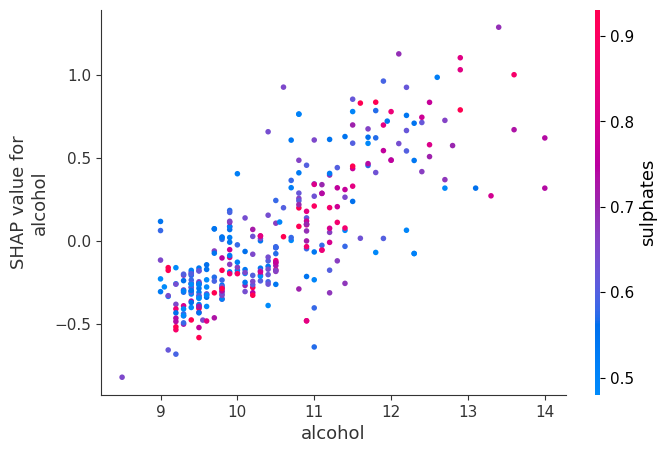

In [15]:
# YOUR CODE 
# make dependence plot
shap.dependence_plot("alcohol", shap_values, X_test, interaction_index="sulphates")

### Questions :

Describe your plot and indicate what can we get from these plots ?  


What can we get from the color axis here ?



*Answers:*

Each dot is a prediction from the dataset. The x-axis is the value of the feature (alcohol). The y-axis is the SHAP value for that feature, which represents how much knowing that feature's value changes the output of the model for that sample's prediction.

The color corresponds to a second feature (sulphates) that may have an interaction effect with the feature we are plotting. If an interaction effect is present between this other feature and the feature we are plotting it will show up as a distinct vertical pattern of coloring. That is not the case for our plot.

---

*Réservé pour corrections*
<div class="alert alert-block alert-info">
<b>Corrections: /4 </b>
</div>

Commentaires: 

---
## 3 Local explanation 

### Local explanation with SHAP

SHAP can also be used to make **local** explanation i.e compute shap values for one instance 

A model is often use to make prediction on new instance thus it is important to be able to explain it 

### Complete the code 

1. Using regressor compute the SHAP value for the instance define in the next cell

2. Print the prediction and the true label 

3. Use [shap.plot.waterfall](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.waterfall_plot.html) to plot the SHAP values


In [16]:
# recompute shap values (needed to use waterfall plot)
shap_values = explainer_re(X_test)

# we define an instance to investigate
index = 66
X_test.iloc[index]

fixed acidity            7.70000
volatile acidity         0.43000
citric acid              0.25000
residual sugar           2.60000
chlorides                0.07300
free sulfur dioxide     29.00000
total sulfur dioxide    63.00000
density                  0.99615
pH                       3.37000
sulphates                0.58000
alcohol                 10.50000
Name: 225, dtype: float64

In [17]:
# YOUR CODE 
# print the prediction by *regressor* and the true label for instance index=66
pred = regressor.predict(X_test.iloc[[index]])[0]
true_label = y_test.iloc[index]
print(f"Prediction: {pred:.0f}\nTrue label: {true_label}")

Prediction: 3
True label: 3


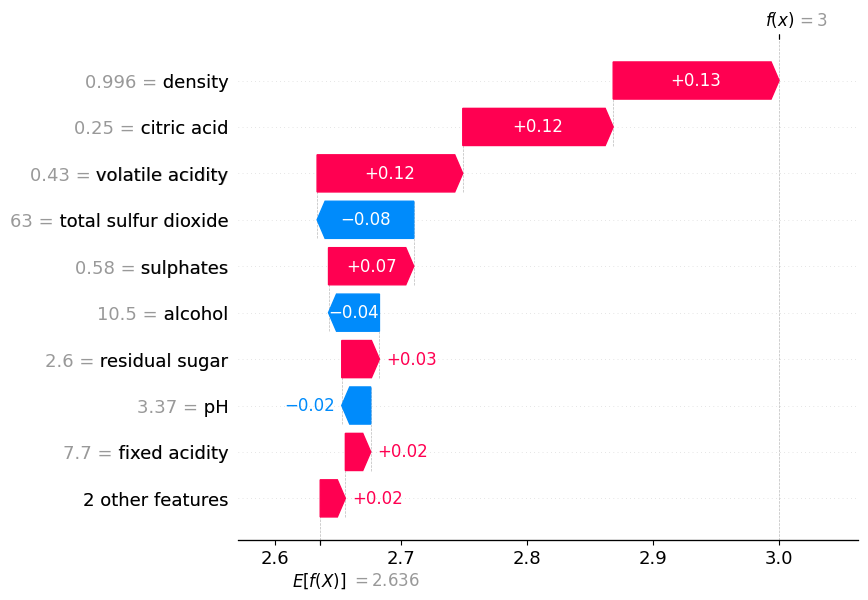

In [18]:
# YOUR CODE
# make a waterfall plot of the prediction index = 66
shap.waterfall_plot(shap_values[index])

### Question :

Describe what the waterfall plot is showing ? 


What does mean the label on the x-axis : E[f(x)] ?



*Answers:*

The waterfall plot displays how each individual feature contributes to the final prediction made by the model for a specific data instance.

It starts from the model’s expected value (the average prediction across the whole dataset), then adds or subtracts the SHAP values of each feature step by step.

Each bar shows whether the feature pushes the prediction up or down, and by how much.

- Red bars indicate a positive contribution to the prediction (they increase it).

- Blue bars indicate a negative contribution (they reduce it).

The sum of all contributions plus the expected value gives the final output f(x) for that specific observation.

$\mathbb{E}[f(x)]$ represents the expected value of the model’s prediction, i.e., the average prediction over all training examples.

It is the baseline prediction: what the model would output if it had no information about the input features.

In practice, this is computed as the mean of the model outputs on the training set (or SHAP background set).

From this baseline, SHAP values show how each feature shifts the prediction up or down to reach the final value f(x) for the instance being explained.

---

*Réservé pour corrections*
<div class="alert alert-block alert-info">
<b>Corrections: /4 </b>
</div>

Commentaires: 

### 3.2 Local explanation with LIME 

[Lime](https://github.com/marcotcr/lime) is another widely used method to compute local explanation. It works completely differently than SHAP but we can also use it to compute local importance per features.  

#### Complete the code : 

1. Use Lime  (the lime.lime_tabular.LimeTabularExplainer module) to create a lime explainer using the training data
2. Use lime explainer.explain_instance to make a plot for instance index=66
 


In [19]:
# YOUR CODE 
# create a lime explainer using the training data
from lime.lime_tabular import LimeTabularExplainer
explainer = LimeTabularExplainer(training_data=X_train.values, training_labels=y_train, feature_names=X_train.columns.tolist(),
    class_names=['quality'],
    mode='regression')

In [20]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

exp = explainer.explain_instance(
    data_row=X_test.iloc[index], 
    predict_fn=regressor.predict,
    
)

In [21]:
# Code required because of python 3.13
from IPython.display import display, HTML
display(HTML(exp.as_html()))

### Questions : 

Compare your Lime and SHAP result : 

*Answer:*

Both methods predict the same value (3.0), but the way they explain how this result was obtained is very different. The features with positive or negative impact on the prediction also differ. For example, the SHAP plot shows that the features "density", "citric acid", and "volatile acidity" had the greatest impact (either positive or negative) on the prediction. In contrast, the LIME plot suggests that, aside from the strong effect of "volatile acidity", features like "density" and "citric acid" have almost no influence.

---

### Questions : 


Conceptually what are the differences you might find between global and local prediction ? 

Imagine you are doctor and you are using a model to classify general health based on some measurements, you now have to explain to your patient the outcome of your model : conceptually how could you use global prediction to explain your patient ? and how could you use local prediction ? 


*Answers:*

Conceptual answer: Feature importance may differ significantly between global and local predictions. Global prediction provides insight into which features are generally most influential across the entire dataset, while local prediction focuses on which features were most important for a specific individual prediction.

Doctor answers: For the global prediction the doctor could say "These are the key health factors that the model considers important for predicting health outcomes across all patients". For the local one, the doctor could say "Based on your personal measurements, these are the specific factors that most influenced your individual result".

---

*Réservé pour corrections*
<div class="alert alert-block alert-info">
<b>Corrections: /6 </b>
</div>

Commentaires: 

## 4. Open the black box 

Now that we have mutliple tools to understand a model's prediction we will focus on new instance and try to really understand what is going on by opening the black box 



### 4.1 Explain prediction on a new vine : 

Here we define a new wine called *new_wine* by adding noise to the mean of our test sample. Then I set the alcohol value to 16. This is a **very** high and unusual value for a wine thus this should have an clear impact on the prediction. 

In [22]:
# let's create a new vine data by adding noise to the training data mean
np.random.seed(1)

new_wine = X_test.mean(axis=0) 
gap = np.array(X_test.mean(axis=0)) 
noise = np.random.uniform(low=-gap*0.5, high=gap*0.5, size=gap.shape)

# we set the alcohol value to 16 (very strong vine)

new_wine = new_wine + noise
new_wine['alcohol'] = 16
new_wine

fixed acidity            7.647104
volatile acidity         0.638153
citric acid              0.136781
residual sugar           2.081050
chlorides                0.055213
free sulfur dioxide      9.188652
total sulfur dioxide    32.580204
density                  0.842753
pH                       2.975306
sulphates                0.687112
alcohol                 16.000000
dtype: float64

### Question : 

Imagine you are a wine seller looking for new products to sell. To help you, you use your regressor model to predict how good a wine is. One day, a wine producer shows you their new wine (which we'll call "new_wine"). You have all the necessary data, you can use your model and XAI knowledge to decide whether or not to purchase the new wine.

Using your regressor model and your XAI knowledge, decide whether or not to buy the new wine.

In [45]:
# YOUR CODE 
# Use regressor to make a prediction (here as new_wine is a new example we do not have the true label)
regressor.predict(new_wine.to_frame().T)

array([5.])

Good news ? 

In [43]:
# we can compute the shap value for this new vine

new_wine_shap_values = explainer_re(np.array([new_wine]))

### Complete the code below : 

Complete the code below to understand how each features contributed to the prediction :

*hint : a plot we used before could help you*


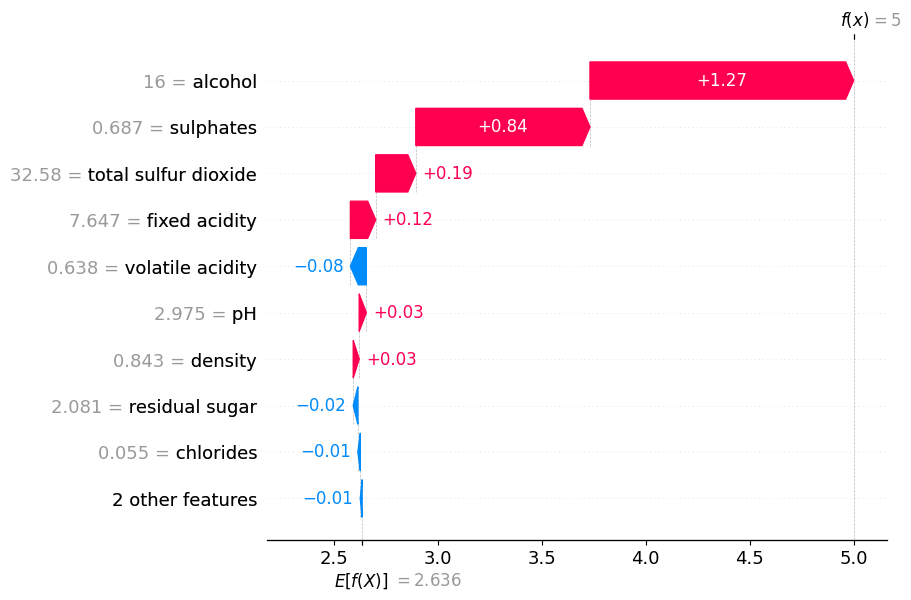

In [42]:
# YOUR CODE
shap.waterfall_plot(new_wine_shap_values[0])

### Questions : 

Comment the 5 quality predicted  by the model regarding the feature contribution : 

How the alcohol value impacted the model ? 

Can we have fully confidence in our black box model ? comment

Use your expert knowledge (here you know that 16 alcohol degree is unusual and probably weird) to choose wether or not to buy the **new_wine**. Comment and explain your decision.

*Answers:*

**REPRENDRE ICI**

The five most important features impacting the predicted quality are: alcohol, sulphates, total sulfur dioxide, fixed acidity, and volatile acidity.
Among them, alcohol, sulphates, total sulfur dioxide, and fixed acidity have a positive contribution, meaning they tend to increase the predicted quality. Volatile acidity, on the other hand, has a negative contribution, meaning it tends to lower the predicted quality score.

Specifically, alcohol has the largest positive impact on the model's prediction, with a contribution of +1.27, which accounts for over 53% of the difference between the model’s base prediction and the final predicted score. This highlights the strong influence of alcohol content on perceived wine quality within the model.

We can't trust the black box because **new_wine** isn't actually a wine, because of the alcohol content. In that sense, the black box model is extrapolating the quality of liquor.

We should be cautious when trusting this black-box model. While it performs well within the range of typical data, it may produce unreliable results when faced with outliers or unrealistic inputs.In this case, the new_wine contains 16% alcohol, which is unusual or even implausible for a standard wine. Such a high value suggests that the product may not be wine at all, but perhaps a fortified wine or liquor. Since the model was trained on regular wines, it is extrapolating beyond its training distribution. Therefore, its prediction for this kind of product is not reliable

Given the abnormally high alcohol level, it is not reasonable to trust the model’s prediction for new_wine.
From an expert perspective, 16% alcohol is atypical for wines and could indicate a data error or a different beverage category. Therefore, despite the high predicted quality, we would not buy new_wine, as the input falls outside of the model's valid domain and undermines the reliability of the prediction.

---

*Réservé pour corrections*
<div class="alert alert-block alert-info">
<b>Corrections: /8 </b>
</div>

Commentaires: 

### 4.2 Understanding Good and Bad Model Predictions

#### Question:

In the next cell, I provide two instances from the test set: `good_instance`, which is correctly predicted by the model, and `bad_instance`, which is poorly predicted.

Explain the differences between these two instances. Why does the model perform well on `good_instance` while misclassifying `bad_instance`? You may use any methods you want, compute values, create plots, etc, to illustrate your explanation. Provide a detailed discussion on why the model performs well on one instance and poorly on the other.

To ensure that the predictions match the expectations, you can use `regressor2` here.

In [ ]:
good_instance1 = X_test.iloc[15] #label = 4
good_instance2 = X_test.iloc[129] #label = 1

bad_instance1 = X_test.iloc[85] # label = 1 pred = 4
bad_instance2 = X_test.iloc[111] # label = 4 pred = 1

for idx in [15, 129, 85, 111]:

     print(f"The true label is {y_test.iloc[idx]} and the regressor prediction is \
    {regressor.predict((np.array(X_test.iloc[idx])).reshape(1,-1))[0] }")

The true label is 4 and the regressor prediction is     4.0
The true label is 1 and the regressor prediction is     1.0
The true label is 1 and the regressor prediction is     4.0
The true label is 4 and the regressor prediction is     1.0


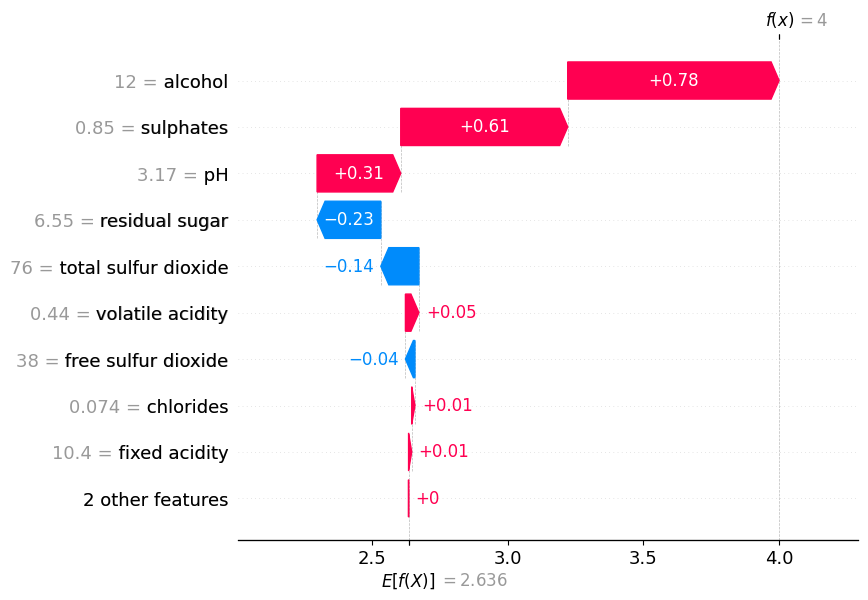

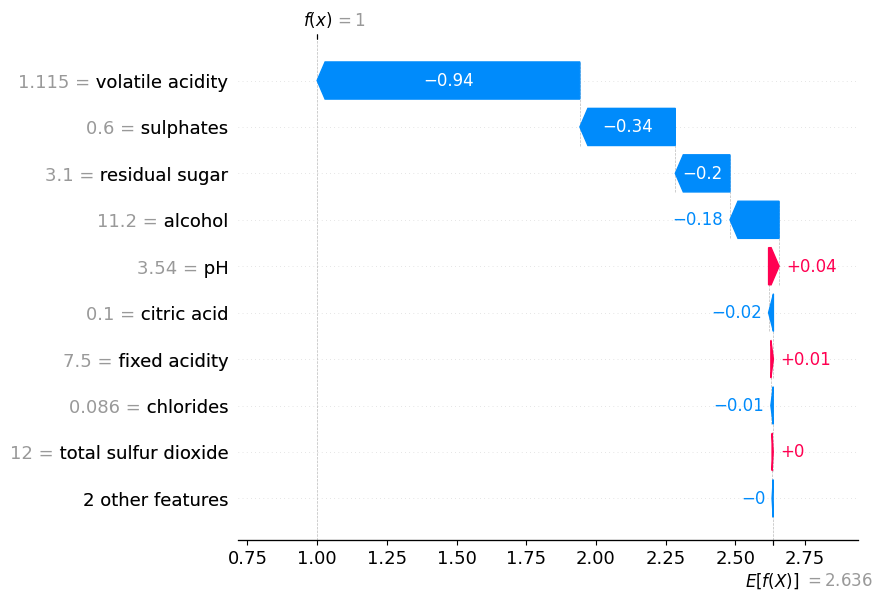

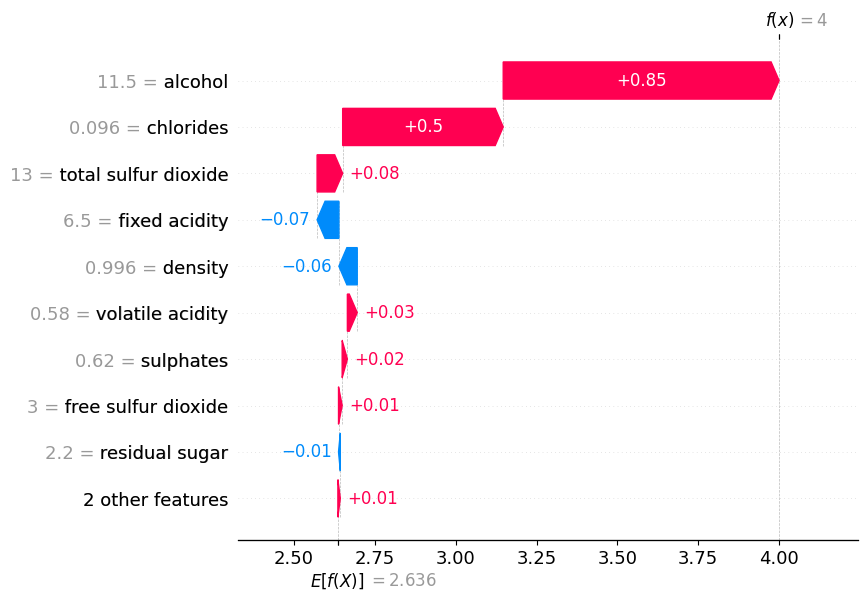

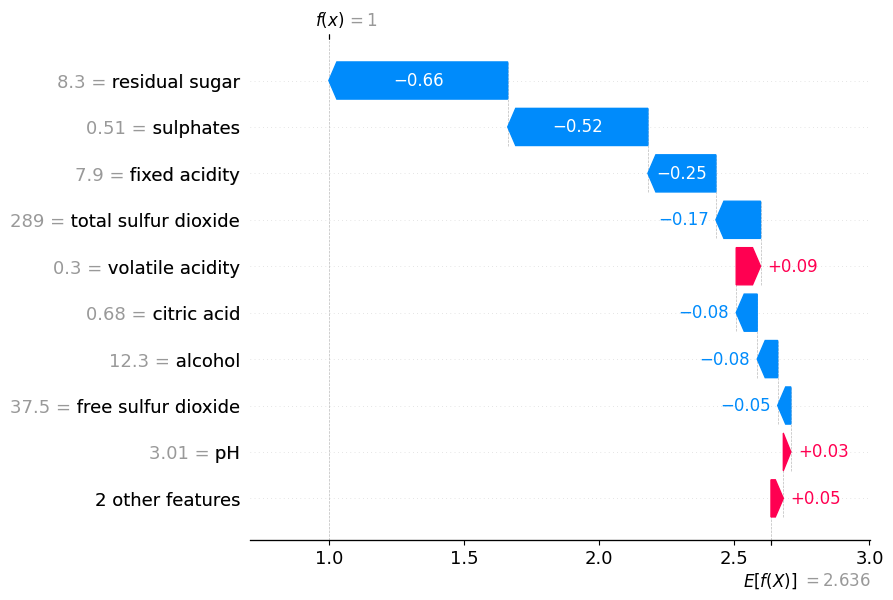

In [51]:
# YOUR CODE 
shap.waterfall_plot(shap_values[15])
shap.waterfall_plot(shap_values[129])
shap.waterfall_plot(shap_values[85])
shap.waterfall_plot(shap_values[111])

# YOUR COMMENT/ANSWER

To understand why the model performs well on some instances and poorly on others, we analyze two correctly predicted examples and two misclassified ones using SHAP values to interpret feature contributions. The goal is to identify what drives model accuracy in some cases and what causes it to fail in others.

In the case of good_instance1 (index 15), the true label is 4 and the model also predicts 4. This alignment is largely due to strong positive contributions from key features. Alcohol at 12% contributes +0.78 to the prediction, sulphates at 0.85 contribute +0.61, and pH at 3.17 adds +0.31. These features are well aligned with what the model has likely learned during training that higher alcohol and sulphate levels are correlated with better wine quality. The residual sugar and sulfur dioxide values have small negative effects, but they are not significant enough to counteract the dominant positive features. The model, in this case, correctly weights the strong indicators of quality and produces an accurate prediction.

Similarly, in good_instance2 (index 129), the true label is 1 and the model also predicts 1. Here, the instance is characterized by several features known to correlate with poor quality. Volatile acidity is high at 1.115, contributing -0.94 to the prediction. Sulphates are moderate at 0.6 and contribute -0.34, while alcohol at 11.2% adds a small negative impact. In total, these features create a consistent downward pull on the prediction, aligning with the true low label. The model performs well here because the signal from volatile acidity, in particular, is strong and unambiguous.

In contrast, bad_instance1 (index 85) is a misclassification. The true label is 1, but the model predicts 4. This error arises because the model incorrectly interprets some features as positive signals when they may not be. Alcohol is at 11.5%, contributing +0.85, and chlorides are at 0.096, contributing +0.50. However, high chloride content is typically associated with lower wine quality, and this reveals a weakness in the model's internal logic in the sens that it treats a harmful feature as beneficial. The lack of strong negative contributions, such as volatile acidity or low sulphates, means the model has no strong signal to pull the prediction back down. Consequently, the model overestimates the quality.

A similar failure occurs in bad_instance2 (index 111), where the true label is 4, but the model predicts 1. Despite an alcohol content of 12.3%, which would usually support a higher quality prediction, the model is dominated by several negative contributions. Residual sugar is high at 8.3 and contributes -0.66, sulphates are moderate at 0.51 and contribute -0.52, and fixed acidity at 7.9 adds -0.25. Even the high alcohol only contributes -0.08, suggesting the model does not fully use this positive feature. This instance illustrates that the model may be overly sensitive to residual sugar and moderate sulphate levels, especially in combination. The strong negative contributions outweight the positive ones, leading to a significantly underpredicted quality score.

Overall, the model performs well when the feature signals are clear and match typical patterns seen in the training data. High alcohol, high sulphates, and low volatile acidity drive predictions upwards appropriately in well-predicted instances. However, in misclassified examples, the model either misinterprets certain features - such as treating chlorides as beneficial - or fails to recognize compensatory factors like high alcohol content in the presence of residual sugar. These failures reflect the model's limitations in handling complex feature interactions and edge cases, and suggest that it lacks nuanced domain understanding. Improvements could involve incorporating domain-specific rules, enhancing the training set with more diverse examples, or employing models better suited for capturing non-linear relationships and interactions.

It is important to note that SHAP values explain how the model uses features to make predictions, not how these features causally determine wine quality in the real world. The model may rely on correlations or patterns in the data that do not reflect true causal relationships (see your comment below).

---
*Réservé pour corrections*
<div class="alert alert-block alert-info">
<b>Corrections: /6 </b>
</div>

Commentaires: 

---
**Note on Interpretability vs. Causality**

SHAP values and LIME like many other post-hoc explainability methods such as permutation importance, and feature importance in tree-based models — explain how a **model** uses input features to make **predictions**. 

They do not tell us how these features truly cause the target variable in the real world. This is a general limitation of model interpretation: even if a model is highly accurate, it might rely on spurious patterns, correlations, or proxy variables that do not reflect actual causal relationships. Therefore, explanations from a Post-Hoc method should be used to understand **model behavior**, not to infer causal mechanisms.

---
*Réservé pour corrections*
<div class="alert alert-block alert-info">
<b>Corrections: /2 </b>
</div>

Commentaires: 

## 5. Impementing Lime step by step 


In this section we will try to compute the lime values by ourselves instead of using the library. We will use the same but simpler dataset. We threshold the quality at six to have a binary classification task (either 0 or 1) and we will use only two features. This will help us to explain and visualize the result

Lime values can be computed in 5 steps :

1. Choosing an instance
2. Make perturbations around the instance
3. Making predictions on the perturbed data
4. Weighting the perturbations
5. Training a local model 

If you are interested you can have a look at the [Lime paper here](https://arxiv.org/pdf/1602.04938.pdf)

In [52]:
# same dataset we change the quality 

df = pd.read_csv(dataset_path)
column_names = list(df.columns)
df['quality'] = df['quality'].apply(lambda x: 0 if x < 6 else 1)
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


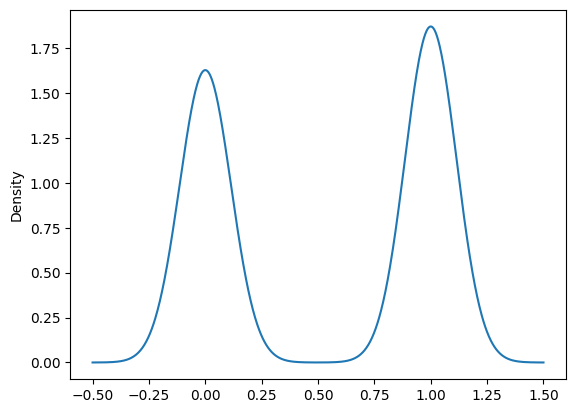

In [53]:
# we can have a look at the label distribution => it is balance
df['quality'].plot(kind='density')

# display the plot
plt.show()

In [61]:
# we use only alchohol and sulphates as features to simplify
from sklearn.ensemble import RandomForestClassifier 
features = ['alcohol', 'sulphates']
X = StandardScaler().fit_transform(df[features])
y = df['quality'].values

# random split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=SEED)

# create and fit a model here we will use a simple random forest classifier
classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)

y_predicted = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_predicted)

# Let's see how well our model performed
tn, fp, fn, tp = confusion_matrix(y_test,y_predicted).ravel()
recal = tp/(tp+fn)
precision = tp/(tp+fp)

print("accuracy = {acc:0.3f},\nrecall = {recal:0.3f},\nprecision = {precision:0.3f}".format(
        acc=accuracy, recal=recal,precision=precision))

accuracy = 0.715,
recall = 0.718,
precision = 0.745


#### Step 1 : choose an instance 

In [62]:
# you can choose any instance from the test set, Xi will be the instance we will try to explain

Xi = X_test[298]
Xi

array([-0.39704261,  0.06993732])

#### Step 2 : make perturbation around the instance 

#### Complete the function below and use it to make perturbation

You need to return X_perturb which are random points around an instance 

In [ ]:
### YOUR CODE HERE
### COMPLETE THE FUNCTION 

def make_perturbations(instance, sigma=0.5, num=750, seed=2023):
    np.random.seed(seed=seed)

    base = np.tile(instance, (num, 1))
    
    noise = np.random.normal(loc=0, scale=sigma, size=base.shape) # we assume that the noise is normally distributed centered around 0 and of standard deviation sigma
    
    perturbed = base + noise # we assume that the noise is additive and independent of the value of the instance
    
    return perturbed
    
X_perturb = make_perturbations(Xi)

#### Step 3 : Making predictions on the perturbed data

In [65]:
### YOUR CODE HERE

y_perturb = classifier.predict(X_perturb)

#### Step 4 : Weighting the perturbations

Try to understand what the function is doing

The kernel gives a larger weight to perturbations closer by the instance than those further away. The kernel_width sets a scale for locality: decreasing this value will give more importance to perturbations that lie closer by the instance.

In [67]:
def get_weights(instance, X_perturb, kernel_width):
    distances = np.sum((instance - X_perturb)**2, axis=1)
    weights = np.sqrt(np.exp(-(distances**2)/(kernel_width**2))) #Kernel function
    return weights

weights = get_weights(Xi, X_perturb, kernel_width=0.9)

#### Step 5 : Training a local model

#### Complete the code below : 

Complete the get local coeffs function, you need to fit a (weighted) **linear regression model** on the perturbed and return the coefficient and the intercept of the linear model 

In [68]:
### YOUR CODE HERE
### complete the function
from sklearn.linear_model import LinearRegression

def get_local_coeffs(X_perturb, y_perturb, weights):
    local_model = LinearRegression()
    local_model.fit(X_perturb, y_perturb, sample_weight=weights)
    
    coefs = local_model.coef_
    intercept = local_model.intercept_
    
    return coefs, intercept

(a,b), c = get_local_coeffs(X_perturb, y_perturb, weights)

In [69]:
# PRINT THE COEFFs AND INTERCEPT

print(f"Alcohol coef : a = {a}")
print(f"Sulphate coef : b = {b}")
print(f"Intercept: c = {c}")

Alcohol coef : a = 0.3377718929203424
Sulphate coef : b = 0.2645948133969047
Intercept: c = 0.5996987054508468


### Questions : 

How do you interpret the coefficient for the alcohol and the sulphates ? How did we call them before ? 

Can we use these values to interpret any new instance ? Why ? 

*Answers:*

The coefficients computed for alcohol and sulphates in this local linear model are interpreted as the local importance of each feature for the specific instance we selected, namely `Xi = [-0.397, 0.0699]`. The coefficient for alcohol is approximately 0.34, meaning that an increase of one unit (in standardized terms) in the alcohol value, holding sulphates constant, would locally increase the predicted probability of the wine being classified as high quality by about 0.34. Similarly, the coefficient for sulphates is approximately 0.26, indicating a slightly weaker but still positive contribution. These values correspond to what we previously referred to as LIME values (or more generally local feature attributions). They tell us how much each feature influences the prediction in the immediate vicinity of the instance being explained.

However, these coefficients are not valid globally. They are only meaningful in the local neighborhood of the selected instance, because they result from fitting a linear approximation to a potentially highly nonlinear model (in this case, a random forest) within a restricted region of the input space. Since the model behaves differently in other regions - due to interactions, non-linear thresholds, and feature dependencies - the same linear coefficients cannot be used to interpret a different instance. Therefore, while these LIME values are very helpful for understanding why the model made a particular prediction for a given input, they cannot be generalized to interpret new or unseen instances. Each new point would require its own local approximation to obtain accurate and meaningful explanations.

---

---
*Réservé pour corrections*
<div class="alert alert-block alert-info">
<b>Corrections: /7 </b>
</div>

Commentaires: 

#### Visualization :

The next cell should plot the step 2,3 and 4. Make change if needed to visualize the plot

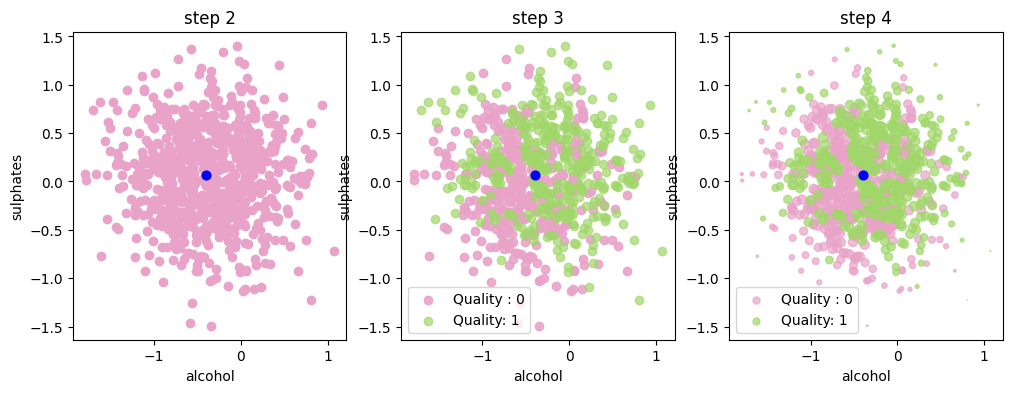

In [ ]:
x1, x2 = X_perturb[y_perturb == 0], X_perturb[y_perturb == 1]
s1, s2 = weights[y_perturb == 0], weights[y_perturb == 1]

fig, axs = plt.subplots(1,3, figsize = (12,4))

axs[0].scatter((X_perturb)[:, 0], (X_perturb)[:, 1], c="#e9a3c9")
axs[0].scatter(Xi[0], Xi[1], c="blue", marker="o", s=40)
axs[0].set_xlabel(features[0])
axs[0].set_ylabel(features[1])
axs[0].set_title("step 2")

axs[1].scatter((x1)[:,0],(x1)[:,1], c="#e9a3c9", alpha=0.9, label='Quality : 0')
axs[1].scatter((x2)[:,0],(x2)[:,1], c="#a1d76a", alpha=0.7, label = 'Quality: 1')
axs[1].scatter(Xi[0],Xi[1],c="blue",marker="o",s=40 )
axs[1].set_xlabel(features[0])
axs[1].set_ylabel(features[1])
axs[1].legend()
axs[1].set_title("step 3")

axs[2].scatter((x1)[:,0],(x1)[:,1], c="#e9a3c9", alpha=0.7, s=50*s1, label='Quality : 0')
axs[2].scatter((x2)[:,0],(x2)[:,1], c="#a1d76a", alpha=0.7, s=50*s2, label = 'Quality: 1')
axs[2].scatter(Xi[0],Xi[1],c="blue",marker="o",s=40 )
axs[2].set_xlabel(features[0])
axs[2].set_ylabel(features[1])
axs[2].legend()
axs[2].set_title("step 4")

plt.show()

#### Good Job ! The last questions are bonus, so answer it if you want to :) 


## Bonus questions : 

What is the local decision boundary of our binary classification task ?

Can you express it mathematically ? 

Can you plot it ? 

*Answers:*

The local decision boundary in this binary classification task corresponds to the boundary learned by the local linear model trained in Step 5 of the LIME procedure. This model is not the global random forest classifier, but rather a local approximation of its behavior around the selected instance `Xi` (`= X_test[298]`). It is a linear classifier, which means the boundary it defines is a straight line in the feature space (here, alcohol and sulphates), and it separates the space into two regions where the model locally predicts either class 0 or class 1.

Mathematically, this decision boundary is the set of points $(x_1, x_2)$ (i.e. alcohol and sulphates values) where the local linear model predicts exactly 0.5, since that is the threshold for binary classification. The prediction function of the local model is : $\hat{y} = a \cdot x_1 + b \cdot x_2 + c$.

The decision boundary is defined by : $a \cdot x_1 + b \cdot x_2 + c = 0.5$

With the actual coefficients obtained previously :

- $a = 0.33777$ (alcohol)
- $b = 0.26459$ (sulphates)
- $c = 0.5997$ (intercept)

The decision boundary can be expressed as :$0.33777 \cdot x_1 + 0.26459 \cdot x_2 + 0.5997 = 0.5$, which simplifies to : $0.33777 \cdot x_1 + 0.26459 \cdot x_2 = -0.0997$.

Solving for $x_2$ gives us the equation of the line that represents the decision boundary in the feature space : $x_2 = \frac{-0.0997 - 0.33777 \cdot x_1}{0.26459}$. 

This equation describes a linear relationship between the two features (alcohol and sulphates) that separates the two classes (0 and 1). Plotting this straight line is trivial, as we can simply compute the values of $x_2$ for a range of $x_1$ values (alcohol) and plot them against each other.

**NB** : Even though the perturbed points appear concentrically distributed around the instance, the local decision boundary is linear because LIME fits a simple linear model to approximate the classifier's behavior locally. This linearity is an artifact of the local surrogate model, not of the global decision boundary of the classifier, which can be highly non-linear (as is the case with a random forest).

---

---
*Réservé pour corrections*
<div class="alert alert-block alert-info">
<b>Corrections: /3 </b>
</div>

Commentaires: 

FIN